Source:
https://www.tensorflow.org/lite/performance/post_training_integer_quant

# Post traininf Integer Quantizaton
### Overview

Integer quantization is an optimization strategy that converts 32-bit floating-point numbers (such as weights and activation outputs) to the nearest 8-bit fixed-point numbers. This results in a smaller model and increased inferencing speed, which is valuable for low-power devices such as microcontrollers. This data format is also required by integer-only accelerators such as the Edge TPU.

In this tutorial, you'll train an MNIST model from scratch, convert it into a Tensorflow Lite file, and quantize it using [post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization). Finally, you'll check the accuracy of the converted model and compare it to the original float model.

You actually have several options as to how much you want to quantize a model. In this tutorial, you'll perform "full integer quantization," which converts all weights and activation outputs into 8-bit integer data—whereas other strategies may leave some amount of data in floating-point.

To learn more about the various quantization strategies, read about [TensorFlow Lite model optimization](https://www.tensorflow.org/lite/performance/model_optimization).




## Setup

In [1]:
import logging
logging.getLogger("tensroflow").setLevel(logging.DEBUG)

import tensorflow as tf
import numpy as np
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.8.0


### Generate a TensorFlow Model
We'll build a simple model to classify numbers from the [MNIST dataset](https://www.tensorflow.org/datasets/catalog/mnist).

This training won't take long because you're training the model for just a 5 epochs, which trains to about ~98% accuracy.

In [2]:
# Load the MNIST dataset
mnist= tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
 
# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0


# Define the model architecture
model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28)),
  tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
  tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10)
])

# Train the digit classification model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])
model.fit(
  train_images,
  train_labels,
  epochs=5,
  validation_data=(test_images, test_labels)
)

2023-10-17 20:41:05.725156: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/5
1875/1875 [==============================] - 13s 6ms/step - loss: 0.2981 - accuracy: 0.9160 - val_loss: 0.1472 - val_accuracy: 0.9602
Epoch 2/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1216 - accuracy: 0.9661 - val_loss: 0.0933 - val_accuracy: 0.9716
Epoch 3/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0869 - accuracy: 0.9749 - val_loss: 0.0731 - val_accuracy: 0.9767
Epoch 4/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0711 - accuracy: 0.9794 - val_loss: 0.0690 - val_accuracy: 0.9778
Epoch 5/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0607 - accuracy: 0.9826 - val_loss: 0.0618 - val_accuracy: 0.9795


## Convert to a TensorFlow Lite model

Now you can convert the trained model to TensorFlow Lite format using the TensorFlow Lite [Converter](https://www.tensorflow.org/lite/models/convert), and apply varying degrees of quantization.

Beware that some versions of quantization leave some of the data in float format. So the following sections show each option with increasing amounts of quantization, until we get a model that's entirely int8 or uint8 data. (Notice we duplicate some code in each section so you can see all the quantization steps for each option.)

First, here's a converted model with no quantization:




In [3]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()



2023-10-17 20:42:05.511014: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/sraj/tmp734wvz23/assets


2023-10-17 20:42:08.646779: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-10-17 20:42:08.646865: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.


It's now a TensorFlow Lite model, but it's still using 32-bit float values for all parameter data.



## Convert using dynamic range quantization
Now let's enable the default ``optimizations`` flag to quantize all fixed parameters (such as weights):



In [4]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model_quant = converter.convert()



INFO:tensorflow:Assets written to: /tmp/sraj/tmppeq0b0ve/assets


INFO:tensorflow:Assets written to: /tmp/sraj/tmppeq0b0ve/assets
2023-10-17 20:42:11.431287: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-10-17 20:42:11.431349: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.


The model is now a bit smaller with quantized weights, but other variable data is still in float format.



### Convert using float fallback quantization
To quantize the variable data (such as model input/output and intermediates between layers), you need to provide a [`RepresentativeDataset`](https://www.tensorflow.org/api_docs/python/tf/lite/RepresentativeDataset). This is a generator function that provides a set of input data that's large enough to represent typical values. It allows the converter to estimate a dynamic range for all the variable data. (The dataset does not need to be unique compared to the training or evaluation dataset.) To support multiple inputs, each representative data point is a list and elements in the list are fed to the model according to their indices.




In [5]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
        # Model has only one input so each data point has one element.
        yield[input_value]
        
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

tflite_model_quant = converter.convert()


INFO:tensorflow:Assets written to: /tmp/sraj/tmpci7dwkeq/assets


INFO:tensorflow:Assets written to: /tmp/sraj/tmpci7dwkeq/assets
/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos9-gcc11-opt/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-10-17 20:42:14.555753: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-10-17 20:42:14.555837: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Now all weights and variable data are quantized, and the model is significantly smaller compared to the original TensorFlow Lite model.

However, to maintain compatibility with applications that traditionally use float model input and output tensors, the TensorFlow Lite Converter leaves the model input and output tensors in float:




In [6]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


That's usually good for compatibility, but it won't be compatible with devices that perform only integer-based operations, such as the Edge TPU.

Additionally, the above process may leave an operation in float format if TensorFlow Lite doesn't include a quantized implementation for that operation. This strategy allows conversion to complete so you have a smaller and more efficient model, but again, it won't be compatible with integer-only hardware. (All ops in this MNIST model have a quantized implementation.)

So to ensure an end-to-end integer-only model, you need a couple more parameters...

### Convert using integer-only quantization

To quantize the input and output tensors, and make the converter throw an error if it encounters an operation it cannot quantize, convert the model again with some additional parameters:



In [7]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/sraj/tmpeas1_v9i/assets


INFO:tensorflow:Assets written to: /tmp/sraj/tmpeas1_v9i/assets
/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos9-gcc11-opt/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-10-17 20:45:53.091235: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-10-17 20:45:53.091297: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
fully_quantize: 0, inference_type: 6, input_inference_type: 3, output_inference_type: 3


The internal quantization remains the same as above, but you can see the input and output tensors are now integer format:



In [8]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input:', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output:', output_type)

input: <class 'numpy.uint8'>
output: <class 'numpy.uint8'>


Now you have an integer quantized model that uses integer data for the model's input and output tensors, so it's compatible with integer-only hardware such as the [Edge TPU](https://coral.ai/).



### Save the models as files
You'll need a `.tflite` file to deploy your model on other devices. So let's save the converted models to files and then load them when we run inferences below.

In [9]:
import pathlib

tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

24296

### Run the TensorFlow Lite models
Now we'll run inferences using the TensorFlow Lite [``Interpreter``](https://www.tensorflow.org/api_docs/python/tf/lite/Interpreter) to compare the model accuracies.

First, we need a function that runs inference with a given model and images, and then returns the predictions:




In [13]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
    global test_images

    # Initialize the interpreter
    interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    predictions = np.zeros((len(test_image_indices),), dtype=int)
    for i, test_image_index in enumerate(test_image_indices):
        test_image = test_images[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
        input_scale, input_zero_point = input_details["quantization"]
        test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

    return predictions

### Test the models on one image
Now we'll compare the performance of the float model and quantized model:

* `tflite_model_file` is the original TensorFlow Lite model with floating-point data.
* `tflite_model_quant_file` is the last model we converted using integer-only quantization (it uses uint8 data for input and output).

Let's create another function to print our predictions:




In [14]:
import matplotlib.pylab as plt

# Change this to test a different image
test_image_index = 1

## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
    global test_labels

    predictions = run_tflite_model(tflite_file, [test_image_index])

    plt.imshow(test_images[test_image_index])
    template = model_type + " Model \n True:{true}, Predicted:{predict}"
    _ = plt.title(template.format(true= str(test_labels[test_image_index]), predict=str(predictions[0])))
    plt.grid(False)

Now test the float model:



INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


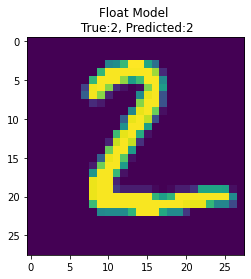

In [15]:
test_model(tflite_model_file, test_image_index, model_type="Float")

And test the quantized model:



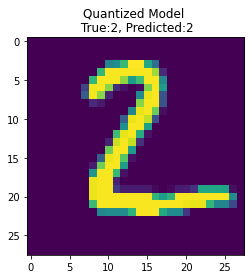

In [16]:
test_model(tflite_model_quant_file, test_image_index, model_type="Quantized")

# Evaluate the models on all images
Now let's run both models using all the test images we loaded at the beginning of this tutorial:

In [20]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
    global test_images
    global test_labels

    test_image_indices = range(test_images.shape[0])
    predictions = run_tflite_model(tflite_file, test_image_indices)

    accuracy = (np.sum(test_labels== predictions) * 100) / len(test_images)

    print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
          model_type, accuracy, len(test_images)))

Evaluate the float model:



In [21]:
evaluate_model(tflite_model_file, model_type="Float")

Float model accuracy is 9.8100% (Number of test samples=10000)


Evaluate the quantized model:



In [22]:
evaluate_model(tflite_model_quant_file, model_type="Quantized")

Quantized model accuracy is 9.8100% (Number of test samples=10000)


So you now have an integer quantized a model with almost no difference in the accuracy, compared to the float model.



To learn more about other quantization strategies, read about [TensorFlow Lite model optimization](https://www.tensorflow.org/lite/performance/model_optimization).



https://www.tensorflow.org/lite/performance/post_training_integer_quant